<a href="https://colab.research.google.com/github/ganeshrohan/Stock_Prediction/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose

In [102]:
data = pd.read_csv('https://raw.githubusercontent.com/dhiwakarK/StockPredictionWhitepaper/main/individual_stocks_5yr/individual_stocks_5yr/ACN_data.csv')
##('/content/ACN.csv')

In [103]:
data.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,160.155,161.13,159.54,160.46,1692576,ACN
1255,2018-02-02,159.980,160.27,156.63,156.90,2183611,ACN
1256,2018-02-05,156.120,159.27,150.73,151.83,3733711,ACN
1257,2018-02-06,150.290,155.18,149.43,154.69,4259634,ACN
1258,2018-02-07,154.220,158.93,153.07,155.15,2918659,ACN


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 69.0+ KB


In [105]:
data.describe()

,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,101.022826,101.766440,100.348163,101.119079,2.596238e+06
std,22.105091,22.206993,21.999712,22.129031,1.353507e+06
min,70.580000,70.750000,69.000000,70.280000,6.018180e+05
25%,80.680000,81.330000,80.165000,80.670000,1.879082e+06
50%,97.800000,98.790000,96.920000,97.770000,2.328702e+06
75%,117.020000,117.990000,116.250000,117.045000,2.972384e+06
max,162.330000,162.600000,160.970000,162.550000,2.828439e+07


<ipython-input-106-8b96879b4d02>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr())


<Axes: >

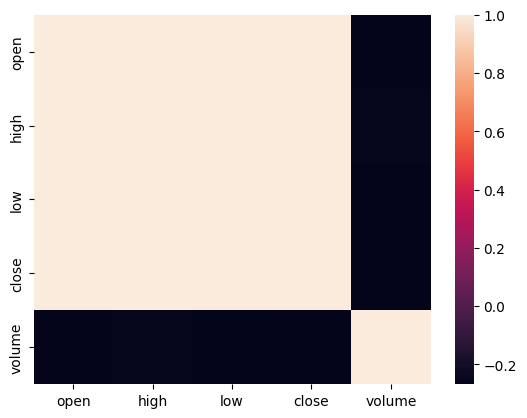

In [106]:
sns.heatmap(data.corr())

In [107]:
def create_lag_and_target(data, lag_days, target_days):
    """
    Create lagged features and target for stock price prediction."""

    # Create lagged features
    for i in range(1, lag_days + 1):
        data[f'close_{i}'] = data['close'].shift(i)

    # Create target for the specified future day
    data['Target'] = data['close'].shift(-target_days)

    # Drop rows with NaN values introduced by lagging
    data = data.dropna()

    return data

In [108]:
# Assuming 'df' is your DataFrame with a 'Close' column
# and you want to create a lag of 40 days and predict the 50th day close price
data = create_lag_and_target(data, lag_days=90, target_days=14)

In [109]:
data.isna().sum()

date        0
open        0
high        0
low         0
close       0
           ..
close_87    0
close_88    0
close_89    0
close_90    0
Target      0
Length: 98, dtype: int64

In [110]:
def detect_seasonality_and_trend(data, period):
    """
    Detects seasonality and trend in the close price and creates new features.
    """

    # Decompose the close price into trend, seasonality, and residuals
    decomposition = seasonal_decompose(data['close_1'], model='multiplicative', period=period)

    # Extract trend and seasonality components
    data['trend'] = decomposition.trend
    data['seasonality'] = decomposition.seasonal

    return pd.DataFrame(data)

In [111]:
# 'open', 'high', 'low','volume','close'
feature_columns = data.drop(['date','Name','volume','open','high','low','close','Target'],axis=1)
print(feature_columns.columns)

Index(['close_1', 'close_2', 'close_3', 'close_4', 'close_5', 'close_6',
       'close_7', 'close_8', 'close_9', 'close_10', 'close_11', 'close_12',
       'close_13', 'close_14', 'close_15', 'close_16', 'close_17', 'close_18',
       'close_19', 'close_20', 'close_21', 'close_22', 'close_23', 'close_24',
       'close_25', 'close_26', 'close_27', 'close_28', 'close_29', 'close_30',
       'close_31', 'close_32', 'close_33', 'close_34', 'close_35', 'close_36',
       'close_37', 'close_38', 'close_39', 'close_40', 'close_41', 'close_42',
       'close_43', 'close_44', 'close_45', 'close_46', 'close_47', 'close_48',
       'close_49', 'close_50', 'close_51', 'close_52', 'close_53', 'close_54',
       'close_55', 'close_56', 'close_57', 'close_58', 'close_59', 'close_60',
       'close_61', 'close_62', 'close_63', 'close_64', 'close_65', 'close_66',
       'close_67', 'close_68', 'close_69', 'close_70', 'close_71', 'close_72',
       'close_73', 'close_74', 'close_75', 'close_76', 'close

In [112]:
y = data['Target']
X = data[feature_columns.columns]

In [113]:
X.isnull().sum()

close_1     0
close_2     0
close_3     0
close_4     0
close_5     0
           ..
close_86    0
close_87    0
close_88    0
close_89    0
close_90    0
Length: 90, dtype: int64

In [114]:
y.isnull().sum()

0

In [115]:
X.dropna(inplace=True)

<ipython-input-115-32f8c2353909>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


In [116]:
y.dropna(inplace=True)

In [117]:
split_index = int(len(X) * 0.8)

# Split the data
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [118]:
# Check the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (924, 90)
X_test shape: (231, 90)
y_train shape: (924,)
y_test shape: (231,)


<Axes: >

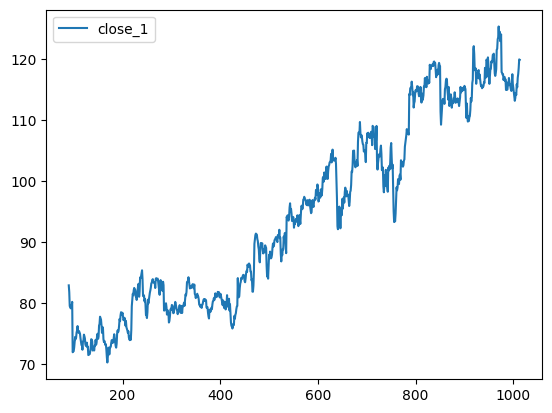

In [119]:
X_train[['close_1']].plot()

In [120]:
X_test

,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,...,close_81,close_82,close_83,close_84,close_85,close_86,close_87,close_88,close_89,close_90
1014,120.72,119.93,120.00,118.59,117.60,116.98,115.43,115.92,114.18,114.49,...,115.59,116.05,116.82,117.53,116.85,118.25,118.11,117.62,116.97,117.46
1015,121.23,120.72,119.93,120.00,118.59,117.60,116.98,115.43,115.92,114.18,...,115.80,115.59,116.05,116.82,117.53,116.85,118.25,118.11,117.62,116.97
1016,122.10,121.23,120.72,119.93,120.00,118.59,117.60,116.98,115.43,115.92,...,115.27,115.80,115.59,116.05,116.82,117.53,116.85,118.25,118.11,117.62
1017,122.21,122.10,121.23,120.72,119.93,120.00,118.59,117.60,116.98,115.43,...,115.45,115.27,115.80,115.59,116.05,116.82,117.53,116.85,118.25,118.11
1018,122.48,122.21,122.10,121.23,120.72,119.93,120.00,118.59,117.60,116.98,...,115.46,115.45,115.27,115.80,115.59,116.05,116.82,117.53,116.85,118.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,158.90,159.46,158.93,157.67,156.38,154.55,153.84,153.09,153.57,153.32,...,135.35,134.86,134.78,136.22,136.23,133.72,134.24,131.12,129.77,130.10
1241,159.11,158.90,159.46,158.93,157.67,156.38,154.55,153.84,153.09,153.57,...,136.94,135.35,134.86,134.78,136.22,136.23,133.72,134.24,131.12,129.77
1242,160.11,159.11,158.90,159.46,158.93,157.67,156.38,154.55,153.84,153.09,...,136.71,136.94,135.35,134.86,134.78,136.22,136.23,133.72,134.24,131.12
1243,157.96,160.11,159.11,158.90,159.46,158.93,157.67,156.38,154.55,153.84,...,138.01,136.71,136.94,135.35,134.86,134.78,136.22,136.23,133.72,134.24


In [121]:
#X_train = detect_seasonality_and_trend(X_train, period=90)  # Assuming daily data with weekly seasonality

In [122]:
# X_test = detect_seasonality_and_trend(X_test, period=90)

In [123]:
# X_train.trend.plot()
# X_train.close_1.plot()

In [124]:
# X_train.seasonality.plot()

In [125]:
def scale_data(data, scale_type):
  scaler = MinMaxScaler()
  if scale_type == 'Reduce':
    scaled_data = scaler.fit_transform(data)
    return pd.DataFrame(scaled_data)
  else:
    reversed_data = scaler.inverse_transform(data)
    return reversed_data

In [126]:
def model_evaluate(y_test,y_pred,model_name):
  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print(f"{model_name} - Mean Squared Error: {mse}")
  print(f"{model_name} - Mean Absolute Error: {mae}")
  print(f"{model_name} - R-squared: {r2}")

In [127]:
def show_graph(y_test,y_pred,model):
  y_pred = pd.DataFrame(y_pred)
  y_pred.index = y_test.index
  plt.plot(y_test, label='Actual')
  plt.plot(y_pred, label='Predicted')
  plt.title(f'{model} - Actual vs Predicted')
  plt.legend()
  plt.show()

# Linear Regression

In [128]:
linear_reg_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('linear_reg', LinearRegression())
])

# Fit the pipeline on the training data
linear_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('linear_reg', LinearRegression())])

In [129]:
X_test

,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,...,close_81,close_82,close_83,close_84,close_85,close_86,close_87,close_88,close_89,close_90
1014,120.72,119.93,120.00,118.59,117.60,116.98,115.43,115.92,114.18,114.49,...,115.59,116.05,116.82,117.53,116.85,118.25,118.11,117.62,116.97,117.46
1015,121.23,120.72,119.93,120.00,118.59,117.60,116.98,115.43,115.92,114.18,...,115.80,115.59,116.05,116.82,117.53,116.85,118.25,118.11,117.62,116.97
1016,122.10,121.23,120.72,119.93,120.00,118.59,117.60,116.98,115.43,115.92,...,115.27,115.80,115.59,116.05,116.82,117.53,116.85,118.25,118.11,117.62
1017,122.21,122.10,121.23,120.72,119.93,120.00,118.59,117.60,116.98,115.43,...,115.45,115.27,115.80,115.59,116.05,116.82,117.53,116.85,118.25,118.11
1018,122.48,122.21,122.10,121.23,120.72,119.93,120.00,118.59,117.60,116.98,...,115.46,115.45,115.27,115.80,115.59,116.05,116.82,117.53,116.85,118.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,158.90,159.46,158.93,157.67,156.38,154.55,153.84,153.09,153.57,153.32,...,135.35,134.86,134.78,136.22,136.23,133.72,134.24,131.12,129.77,130.10
1241,159.11,158.90,159.46,158.93,157.67,156.38,154.55,153.84,153.09,153.57,...,136.94,135.35,134.86,134.78,136.22,136.23,133.72,134.24,131.12,129.77
1242,160.11,159.11,158.90,159.46,158.93,157.67,156.38,154.55,153.84,153.09,...,136.71,136.94,135.35,134.86,134.78,136.22,136.23,133.72,134.24,131.12
1243,157.96,160.11,159.11,158.90,159.46,158.93,157.67,156.38,154.55,153.84,...,138.01,136.71,136.94,135.35,134.86,134.78,136.22,136.23,133.72,134.24


In [130]:
# Make predictions on the test set
y_pred = linear_reg_pipeline.predict(X_test)

In [131]:
linear_reg_pipeline.score(X_test,y_test)

0.848329012649716

In [132]:
model_evaluate(y_test,y_pred,'Linear Regression')

Linear Regression - Mean Squared Error: 25.96680687966492
Linear Regression - Mean Absolute Error: 4.289721337432324
Linear Regression - R-squared: 0.848329012649716


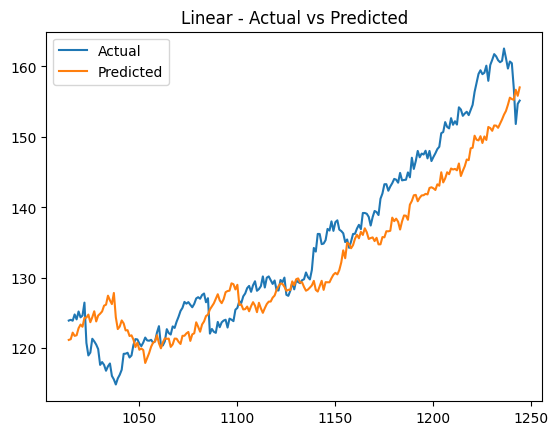

In [133]:
show_graph(y_test,y_pred,'Linear')

In [33]:
y_train

90       74.35
91       75.20
92       75.52
93       76.25
94       75.29
         ...  
1009    123.64
1010    123.24
1011    124.14
1012    124.46
1013    123.18
Name: Target, Length: 924, dtype: float64

In [34]:
print(linear_reg_pipeline.named_steps['linear_reg'].intercept_)
print(linear_reg_pipeline.named_steps['linear_reg'].coef_)

71.30605331608302
[32.54191103  0.61426215  2.66614195  0.19879397  0.54186244  2.28460466
  0.74932486 -3.35282076  0.52649791  3.28755923  1.96764352  2.29217489
 -0.23655575 -3.08753878  2.77754893  7.45554449 -3.98259249 -2.86347368
 -2.29569235  1.22158477 -3.33374307 -1.95439597  5.74375749  1.37084238
 -1.1436635   3.74221964 -1.16666697 -0.52879823  1.58269752 -2.38605109
 -2.37998168  0.2872466   1.9339794   3.35784958 -4.33438267  0.35226529
  2.27912134 -1.05254611 -0.27296813 -3.765561   -0.6978398   0.75682577
  0.98124232  2.84253701 -0.73289491 -0.63341378  0.88517922 -0.86218058
 -0.69465689 -1.89463845  0.04445174 -2.83018517  0.07451983 -0.84768642
  3.49534905  0.31209126 -2.01030688 -1.25115212  2.43631909 -3.29981817
  2.37348118  0.44040007  0.46468169  1.20854802  0.69823783  3.61815928
  2.04700832  0.82377666  0.10988429 -1.96189993  0.24499461  0.62889142
  0.12958049 -2.6492081   3.71917889 -0.26780875  0.08781195 -0.52567949
 -1.04073629  3.78104301 -2.16988

# Polynomial regression

In [ ]:
time_split = TimeSeriesSplit(n_splits=3)

In [36]:
# Create a pipeline with PolynomialFeatures
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('linear_reg', LinearRegression())
])

# # Specify the degrees to be searched
param_grid = {
    'poly_features__degree': [1,2,3]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid,cv=time_split,scoring='neg_mean_squared_error', return_train_score=True)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best degree from the grid search
best_degree = grid_search.best_params_['poly_features__degree']

# Plot the data and the polynomial regression curve
y_pred = grid_search.predict(X_test)

In [37]:
print("Best Degree " + str(best_degree))
print(-grid_search.cv_results_['mean_test_score'])

Best Degree 1
[  26.89089717  349.0729369  2670.29209047]


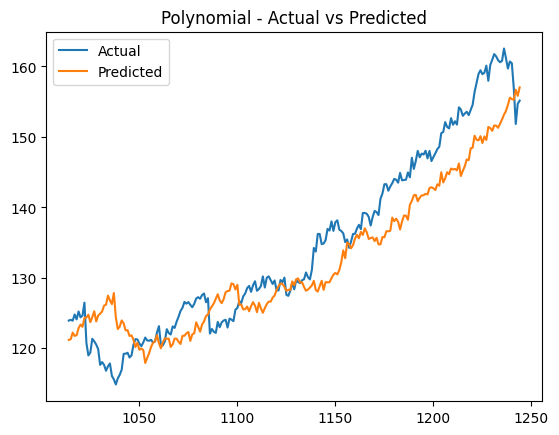

In [39]:
show_graph(y_test,y_pred,'Polynomial')

In [40]:
model_evaluate(y_test,y_pred,'Polynomial regression')

Polynomial regression - Mean Squared Error: 25.966806879664652
Polynomial regression - Mean Absolute Error: 4.2897213374323
Polynomial regression - R-squared: 0.8483290126497176


# Lasso Regression

In [41]:
# Create a pipeline with PolynomialFeatures and Lasso Regression
lasso_pipeline = Pipeline([
    ('MinMax', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('lasso_reg', Lasso(max_iter=2000)) # max_iter=10000
])

# Specify the degrees to be searched
param_grid = {
    'poly_features__degree': [1, 2, 3],
    'lasso_reg__alpha': np.logspace(-4, 2, 7)  # Adjust the range as needed
}

# Create the GridSearchCV object
lasso_grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=time_split, scoring='neg_mean_squared_error', return_train_score=True)

# Perform the grid search
lasso_grid_search.fit(X_train, y_train)

# Get the best degree and alpha from the grid search
best_degree = lasso_grid_search.best_params_['poly_features__degree']
best_alpha = lasso_grid_search.best_params_['lasso_reg__alpha']

print(f"Best Degree: {best_degree}")
print(f"Best Alpha: {best_alpha}")
# Print the negative of mean test scores (as GridSearchCV returns negative values)
print(-lasso_grid_search.cv_results_['mean_test_score'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.917e+00, tolerance: 1.994e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.509e+01, tolerance: 4.014e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e+02, tolerance: 1.637e

Best Degree: 1
Best Alpha: 0.01
[  26.87835981  258.26395338 1200.43870107   26.78950868  122.99937925
  449.04649997   26.64014215   82.67888107  150.25980996   30.05242968
   37.08579106   37.61697843  133.61699194  123.90886743  123.90886743
  364.72321606  364.72321606  364.72321606  364.72321606  364.72321606
  364.72321606]


In [42]:
# Predict using the Lasso model
y_pred = lasso_grid_search.predict(X_test)

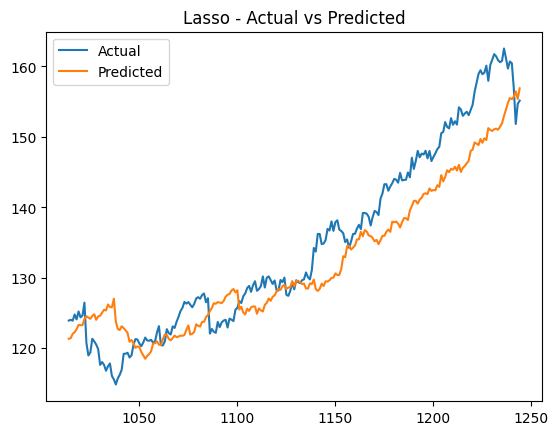

In [43]:
show_graph(y_test,y_pred,'Lasso')

In [44]:
model_evaluate(y_test,y_pred,'Lasso regression')

Lasso regression - Mean Squared Error: 25.611741148515772
Lasso regression - Mean Absolute Error: 4.258010333478514
Lasso regression - R-squared: 0.8504029361115882


In [46]:
# Create a pipeline with PolynomialFeatures, MinMaxScaler, and Ridge Regression
ridge_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('ridge_reg', Ridge(max_iter=2000))
])

# Specify the degrees and alpha to be searched
param_grid = {
    'poly_features__degree': [1, 2, 3],
    'ridge_reg__alpha': np.logspace(-4, 2, 7)  # Adjust the range as needed
}

# Create the GridSearchCV object
ridge_grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=time_split, scoring='neg_mean_squared_error', return_train_score=True)

# Perform the grid search
ridge_grid_search.fit(X_train, y_train)

# Get the best degree and alpha from the grid search
best_degree = ridge_grid_search.best_params_['poly_features__degree']
best_alpha = ridge_grid_search.best_params_['ridge_reg__alpha']


print(f"Best Degree - {best_degree}")
print(f"Best Alpha - {best_alpha}")

Best Degree - 1
Best Alpha - 0.0001


In [47]:

# Plot the data and the Ridge regression curve
y_pred = ridge_grid_search.predict(X_test)

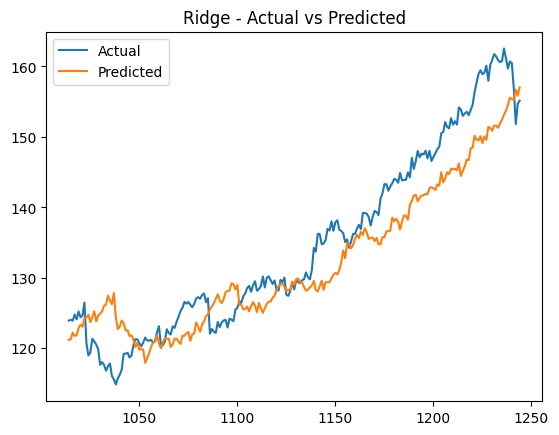

In [48]:
show_graph(y_test,y_pred,'Ridge')

In [49]:
model_evaluate(y_test,y_pred,'Ridge regression')

Ridge regression - Mean Squared Error: 25.96706156209756
Ridge regression - Mean Absolute Error: 4.2897559348269185
Ridge regression - R-squared: 0.8483275250607261


# Elastic Net

In [96]:
# Create a pipeline with PolynomialFeatures, MinMaxScaler, and Elastic Net Regression
elastic_net_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('elastic_net_reg', ElasticNet())
])

# Specify the degrees and alpha to be searched
param_grid = {
    'poly_features__degree': [1, 2, 3],
    'elastic_net_reg__alpha': np.logspace(-4, 2, 7),  # Adjust the range as needed
    'elastic_net_reg__l1_ratio': [0.1, 0.5, 0.9]  # Adjust the ratios as needed
}

# Create the GridSearchCV object
elastic_net_grid_search = GridSearchCV(elastic_net_pipeline, param_grid, cv=time_split, scoring='neg_mean_squared_error', return_train_score=True)

# Perform the grid search
elastic_net_grid_search.fit(X_train, y_train)

# Get the best degree, alpha, and l1_ratio from the grid search
best_degree = elastic_net_grid_search.best_params_['poly_features__degree']
best_alpha = elastic_net_grid_search.best_params_['elastic_net_reg__alpha']
best_l1_ratio = elastic_net_grid_search.best_params_['elastic_net_reg__l1_ratio']

print(f"Best Degree - {best_degree}")
print(f"Best Alpha - {best_alpha}")
print(f"Best L1 Ratio - {best_l1_ratio}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.784e+00, tolerance: 1.994e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e+03, tolerance: 6.333e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.912e+03, tolerance: 1.389e

Best Degree - 1
Best Alpha - 0.001
Best L1 Ratio - 0.9


In [98]:
y_pred = elastic_net_grid_search.predict(X_test)

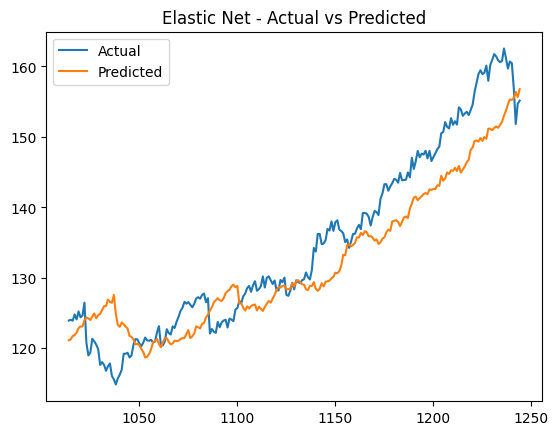

In [99]:
show_graph(y_test,y_pred,'Elastic Net')

In [100]:
model_evaluate(y_test,y_pred,'ElasticNet regression')

ElasticNet regression - Mean Squared Error: 26.17222721544786
ElasticNet regression - Mean Absolute Error: 4.316338010408895
ElasticNet regression - R-squared: 0.8471291614206292
